# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.  
Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и предобработка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib. pyplot as plt
import numpy as np

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline




In [2]:
STATE = np.random.RandomState(123)

In [3]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
df_list = [df0, df1, df2]

In [5]:
def get_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))
    display(data.corr())

In [6]:
for i, df in enumerate(df_list):
    print('df', i)
    get_info(df)
    print('*'*50)

df 0


,id,f0,f1,f2,product
23037,ryU4z,1.186625,-0.434937,3.988315,129.440182
12931,1aDwK,0.697142,-0.582148,4.161505,51.007396
40863,evvZe,0.899278,-0.491615,0.983043,151.582519
707,iu9Sq,1.788334,0.290992,7.615331,124.421488
12132,cr3z0,-0.073945,1.019798,3.755453,75.700668


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,HZww2,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


**************************************************
df 1


,id,f0,f1,f2,product
24542,4x5VA,-6.628218,-3.599478,1.992810,57.085625
12539,QNn1D,-8.096046,-10.485281,0.992764,30.132364
99645,OqUv4,5.455737,-3.511840,2.006199,53.906522
81086,1do3E,0.947710,6.309729,0.002091,0.000000
55889,FLHYx,19.515220,-11.757188,3.990579,107.813044


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,LHZR0,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**************************************************
df 2


,id,f0,f1,f2,product
54076,0U0Pb,0.281279,-0.474021,9.903588,71.497327
48642,NO77v,-3.547806,-0.277068,1.474342,126.406297
64772,fhTkY,-1.048124,0.051298,1.441221,3.800283
66150,MopJX,2.774037,-0.595350,4.182750,64.595792
70406,NEOxf,0.882242,2.334016,0.338000,93.787014


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,Vcm5J,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**************************************************


Мы наблюдаем неуникальные значения в столбце `id`, посмотрим что это такое  
**Так же видим высокую корреляцию признака `f2` и `product` от 0,44 до 0,99. Советуем заказчику обратить на это внимание**

In [7]:
df1[df1.duplicated(subset='id', keep=False)].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Похоже разные данные были записаны на один `id`. Не знаем, какие из них достоверные, удаляем и те, и другие.

In [8]:
df0, df1, df2 = (df.drop_duplicates(subset='id', keep=False).copy() for df in df_list)

In [9]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


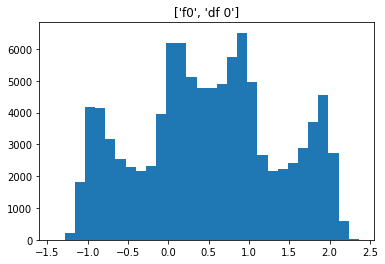

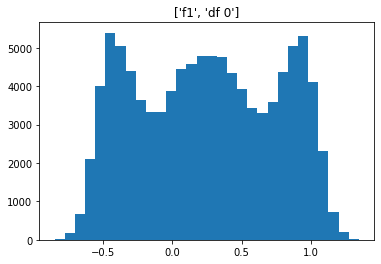

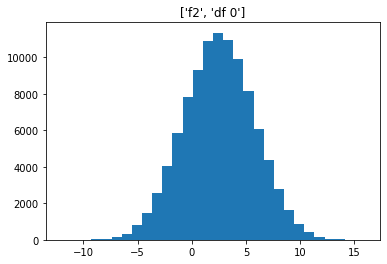

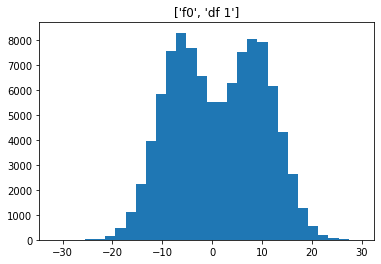

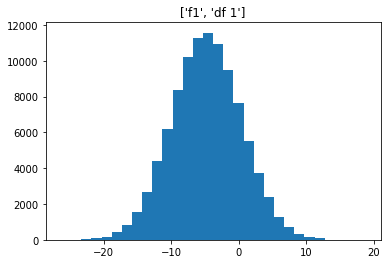

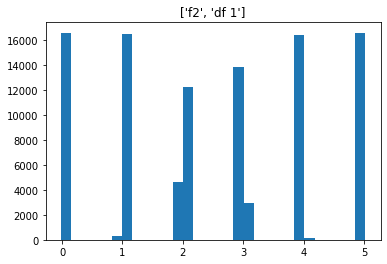

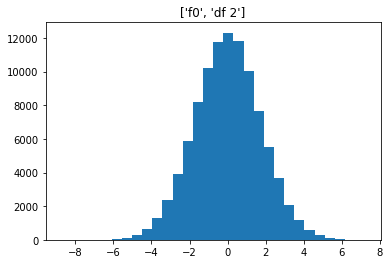

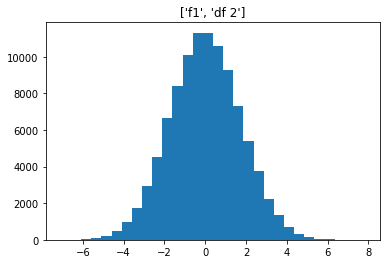

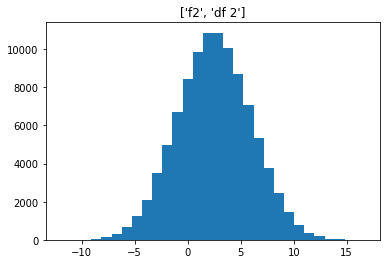

In [10]:
columns_list = ['f0', 'f1', 'f2']
n = 0
for x in df_list:
    for y in columns_list:
    
        plt.figure()
        plt.title([y, f'df {n}'])        
        plt.hist(x[y], bins=30)
        plt.show
    n+=1
             

In [11]:
df1['f2'].value_counts()

 3.996243    1
-0.001450    1
 2.004278    1
 1.996189    1
 0.996936    1
            ..
 3.003466    1
 0.001041    1
 1.003135    1
 4.004630    1
 4.992682    1
Name: f2, Length: 99992, dtype: int64

Такое ощущение, что `f2` в df1 заполнялся иначе, чем в других df. Похоже на категории, однако что-то здесь не так.

## Подготовка к обучению

In [12]:
features0 = df0.drop(['product', 'id'], axis=1)
target0 = df0['product'].to_frame()

features1 = df1.drop(['product', 'id'], axis=1)
target1 = df1['product'].to_frame()

features2 = df2.drop(['product', 'id'], axis=1)
target2 = df2['product'].to_frame()

features1.shape, target1.shape, features2.shape, target2.shape, features0.shape, target0.shape

((99992, 3), (99992, 1), (99992, 3), (99992, 1), (99980, 3), (99980, 1))

In [13]:
features0_train, features0_valid, target0_train, target0_valid = train_test_split(features0, target0, 
                                                                                  test_size=0.25, random_state=STATE)
features1_train, features1_valid, target1_train, target1_valid = train_test_split(features1, target1, 
                                                                                  test_size=0.25, random_state=STATE)
features2_train, features2_valid, target2_train, target2_valid = train_test_split(features2, target2, 
                                                                                  test_size=0.25, random_state=STATE)
features0_train.shape, features0_valid.shape, target0_train.shape, target0_valid.shape

((74985, 3), (24995, 3), (74985, 1), (24995, 1))

В кодировании и масштабировании данные не нуждаются.  
Обучать по условию будем только Линейную Регрессию

## Обучение и проверка модели

In [14]:
model = LinearRegression()

scores0 = cross_val_score(model, features0, target0, cv=5, scoring='neg_mean_squared_error')
scores1 = cross_val_score(model, features1, target1, cv=5, scoring='neg_mean_squared_error')
scores2 = cross_val_score(model, features2, target2, cv=5, scoring='neg_mean_squared_error')

abs(scores0.mean())**0.5, abs(scores1.mean())**0.5, abs(scores2.mean())**0.5

(37.695696252566854, 0.8904399351700024, 40.055257955396755)

Такое различие в результатах мне кажется подозрительным. Явно со вторым регионом что-то не то.  
Я бы обязательно подсветил это перед заказчиком

## Подготовка к расчёту прибыли

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

* предсказать объемы в регионах
* выделить 500 самых перспективных скважин для исследования
* проверить бутстрепом вероятность того, что 200 рандомных скважин из этих 500 не принесут ожидаемой прибыли

In [15]:
BUDGET = 10 ** 10
PRICE = 450000
MAX_RISK = 2.5

In [16]:
min_product = BUDGET/PRICE
print("Минимальный средний объем на одной скважине равен", int(min_product/200))

Минимальный средний объем на одной скважине равен 111


In [17]:
df_list = [df0, df1, df2]
for df in df_list:
    print(df['product'].mean())

92.49916597893444
68.82414772665173
94.99876686768079


Ни один из регионов не дотягивает до минимальных средних показателей, если брать среднее значение по региону.

## Расчёт прибыли и рисков 

In [18]:
features_train_list = [features0_train, features1_train, features2_train]
features_valid_list = [features0_valid, features1_valid, features2_valid]

In [19]:
target_train_list = [target0_train, target1_train, target2_train]
target_valid_list = [target0_valid, target1_valid, target2_valid]

In [21]:
for w, x, y, z in zip(features_train_list, target_train_list, features_valid_list, target_valid_list):
    model.fit(w, x)
    z['predict'] = model.predict(y)

In [25]:
profit_0 = []
profit_1 = []
profit_2 = []
profit_list = [profit_0, profit_1, profit_2]


for _ in range(1000):
    for x, y in zip(profit_list, target_valid_list):
        x.append((y.sample(n=500, random_state=STATE)).sort_values(by='predict', ascending=False). \
                 head(200)['product'].sum()*PRICE-BUDGET)   
        

In [26]:
region_list = ['Региону 0', "Региону 1", "Региону 2"]

for x, y in zip(profit_list, region_list):
    x = pd.Series(x)
    print(f'Средняя прибыль по {y} равна {int(x.mean())}')
    print(f'С вероятностью 95% прибыль установится в промежутке {int(x.quantile(0.025))} и {int(x.quantile(0.975))}' )    
    print(f'Вероятность убытка {round((x<0).mean()*100, 1)}%')
    if (x<0).mean()*100 > MAX_RISK:
        print('Регион не подходит под условия')
    else: print('Регион удовлетворяет условиям')
    print()

Средняя прибыль по Региону 0 равна 442812235
С вероятностью 95% прибыль установится в промежутке -55776523 и 916859783
Вероятность убытка 4.1%
Регион не подходит под условия

Средняя прибыль по Региону 1 равна 450524621
С вероятностью 95% прибыль установится в промежутке 102114371 и 836596435
Вероятность убытка 0.6%
Регион удовлетворяет условиям

Средняя прибыль по Региону 2 равна 354822558
С вероятностью 95% прибыль установится в промежутке -199202052 и 900867330
Вероятность убытка 9.5%
Регион не подходит под условия



## Вывод

В ходе исследования мы обучили на предоставленных данных три модели (по одной для каждого региона).  
На основании предсказаний моделей мы 1000 раз выбрали 500 случайных скважин и посчитали прибыль по 200 лучшим из них.  
  
**По результатам исследования наиболее подходящим регионом для разработки является Регион 1 по наименьшей вероятности убытка.**  